In [5]:
import pandas as pd
import numpy as np
import datetime as dt
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
import requests
from bs4 import BeautifulSoup
from selenium import webdriver
import time
import json
from shapely.affinity import rotate

import folium

Read-in the data

In [6]:
'''turnout_path = '/Users/mattkeeley/Desktop/VS_Code/Election_Sim/Data/turnout_history.csv'
turnout_data = pd.read_csv(turnout_path, header = 1)

inflation_path = '/Users/mattkeeley/Desktop/VS_Code/Election_Sim/Data/cu.data.0.Current.txt'
inflation_data = pd.read_csv(inflation_path, sep = '\t', dtype = {4: object})
inflation_map_path = '/Users/mattkeeley/Desktop/VS_Code/Election_Sim/Data/cu.series'
inflation_map = pd.read_csv(inflation_map_path, sep = '\t')

gdp_path = '/Users/mattkeeley/Desktop/VS_Code/Election_Sim/Data/GDP.csv'
gdp_data = pd.read_csv(gdp_path)

polling_path = '/Users/mattkeeley/Desktop/VS_Code/Election_Sim/Data/president_polls.csv'
polling_data = pd.read_csv(polling_path)
avg_path = '/Users/mattkeeley/Desktop/VS_Code/Election_Sim/Data/presidential_general_averages.csv'
avg_polling_data = pd.read_csv(avg_path)
house_path = '/Users/mattkeeley/Desktop/VS_Code/Election_Sim/Data/house_polls.csv'
house_data = pd.read_csv(house_path)

unemployment_path = '/Users/mattkeeley/Desktop/VS_Code/Election_Sim/Data/state_unemployment.txt'
unemployment_data = pd.read_csv(unemployment_path, sep = '\t', dtype = {3: object})
unemployment_state_path = '/Users/mattkeeley/Desktop/VS_Code/Election_Sim/Data/la.state_region_division'
unemployment_state = pd.read_csv(unemployment_state_path, sep = '\t')
unemployment_statistic_path = '/Users/mattkeeley/Desktop/VS_Code/Election_Sim/Data/la.measure'
unemployment_statistic = pd.read_csv(unemployment_statistic_path, sep = '\t')'''

geometry_path = '/Users/mattkeeley/Desktop/VS_Code/Election_Sim/Data/cb_2018_us_state_500k/cb_2018_us_state_500k.shp'
geometry_data = gpd.read_file(geometry_path)


In [7]:
def save_html(html, path):
    with open(path, 'w') as f:
        f.write(html)
def open_html(path):
    with open(path, 'rb') as f:
        return f.read()

In [8]:
#r = requests.get('https://www.270towin.com/2024-presidential-election-polls/')
driver = webdriver.Chrome()
driver.get('https://www.270towin.com/2024-presidential-election-polls/')
time.sleep(3)
html_content = driver.page_source
driver.quit()

save_html(html_content, '270_road_html')
html = open_html('270_road_html')
#use webdriver() instead

In [9]:
#print(driver.page_source)

In [10]:
soup = BeautifulSoup(html_content, 'html.parser')

In [11]:
rows = soup.select('#polls-pies .pie_div')


In [12]:
state = []
for row in rows:
    state_name = row.select_one('.state_name').text.strip()
    if state_name:
        state.append(state_name)

In [13]:
url = 'https://www.270towin.com/polls/php/get-polls-by-state.php?election_year=2024&candidate_name_dem=Harris&candidate_name_rep=Trump&sort_by=date&include_3Party=false'
polls_url = requests.get(url)

In [14]:

with open('polling_data.json', 'w') as f:
    json.dump(polls_url.json(), f, indent = 4)
with open('polling_data.json', 'r') as f:
    data = json.load(f)

In [15]:
#data

In [16]:
poll_results = []
for state, poll_data in data['results'].items():
    if isinstance(poll_data, dict):
        d = dict()
        d['state'] = state
        d['ev'] = poll_data['state_votes']
        d['poll_date'] = poll_data['poll_date']
        d['poll_rep'] = poll_data['poll_rep']
        d['poll_rep_avg'] = poll_data['poll_rep_avg']
        d['poll_dem'] = poll_data['poll_dem']
        d['poll_dem_avg'] = poll_data['poll_dem_avg']
        d['margin'] = poll_data['margin']
        d['winner_party'] = poll_data['winner_party']
        poll_results.append(d)
        #print(f"{state_name} ({poll_date}): Republican {poll_rep}%, Democrat {poll_dem}%, Winner: {winner_party}")
poll_df = pd.DataFrame(poll_results)
poll_df.loc[poll_df['winner_party'] == 'R', 'margin'] = -poll_df['margin']
poll_df = poll_df.drop(index=0)
poll_df['ev'] = poll_df['ev'].astype('int64')
poll_df

missing_states = pd.DataFrame({
    'state': ['Idaho', 'Wyoming', 'Kansas', 'Louisiana', 'Mississippi', 'Illinois', 'Kentucky', 'Hawaii', 'Alabama', 'District of Columbia', 'Nebraska Dist. 1', 'Nebraska Dist. 3'],
    'ev': [4, 3, 6, 8, 6, 19, 8, 4, 9, 3, 1, 1],
    'poll_rep_avg': [63.8, 69.9, 56.1, 58.5, 57.5, 40.6, 62.1, 34.3, 62, 5.4, 100, 100],
    'poll_dem_avg': [33.1, 26.6, 41.5, 39.9, 41, 57.5, 36.1, 63.7, 36.6, 92.1, 0, 0]
})

missing_states['margin'] = missing_states['poll_dem_avg'] - missing_states['poll_rep_avg']
poll_df = pd.concat([poll_df, missing_states], ignore_index=True, join = 'outer')
poll_df = poll_df.sort_values(by='state', ascending=False)
##### Scrape the data for practice - 2020 election results + state electoral votes

In [17]:
def simulate_state(poll_df, polling_error = 5):
    polling_avg = poll_df['margin']
    random_noise = np.random.normal(0, polling_error)
    prediction = polling_avg + random_noise
    return prediction

def calculate_winner(prediction):
    avg_prediction = prediction.mean()
    if avg_prediction > 0:
        return 'Harris'
    return 'Trump'

def mcmc(poll_df, iterations = 10000):
    harris_wins = 0
    for i in range(iterations):
        result = simulate_state(poll_df)
        winner = calculate_winner(result)
        if winner == 'Harris':
            harris_wins += 1
    win_prob = harris_wins / iterations
    return win_prob

def election_sim(poll_df, iterations = 10000):
    results = {}
    dem_ev = 0
    rep_ev = 0
    for state in poll_df['state'].unique():
        state_polls = poll_df[poll_df['state'] == state]
        win_prob = mcmc(state_polls, iterations)
        state_ev = state_polls['ev'].iloc[0]
        if win_prob > 0.5:
            dem_ev += state_ev
        else:
            rep_ev += state_ev
        results[state] = win_prob
    return results, dem_ev, rep_ev
def bar_prob(results):
    states = list(results.keys())
    probabilities = list(results.values())
    plt.barh(states, probabilities)
    plt.ylabel('States')
    plt.yticks(fontsize = 5)
    plt.xlabel('Probability of Harris Winning State')
    plt.title('State by State Forecast')
    plt.show()

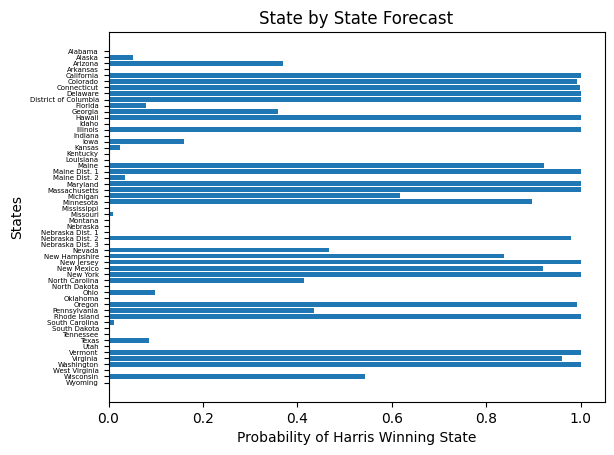

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pyproj/crs/crs.py:143: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [18]:
results, dem_ev, rep_ev = election_sim(poll_df)
bar_prob(results)
results = pd.DataFrame(list(results.items()), columns=['state', 'value'])
gdf = gpd.GeoDataFrame(results.merge(geometry_data, left_on = 'state', right_on = 'NAME')).to_crs({'init': 'epsg:2163'})

##### GDF does not have all states saved, and results is missing ev data

#### Why does gdf drop some states? does it need to be a left join or something?


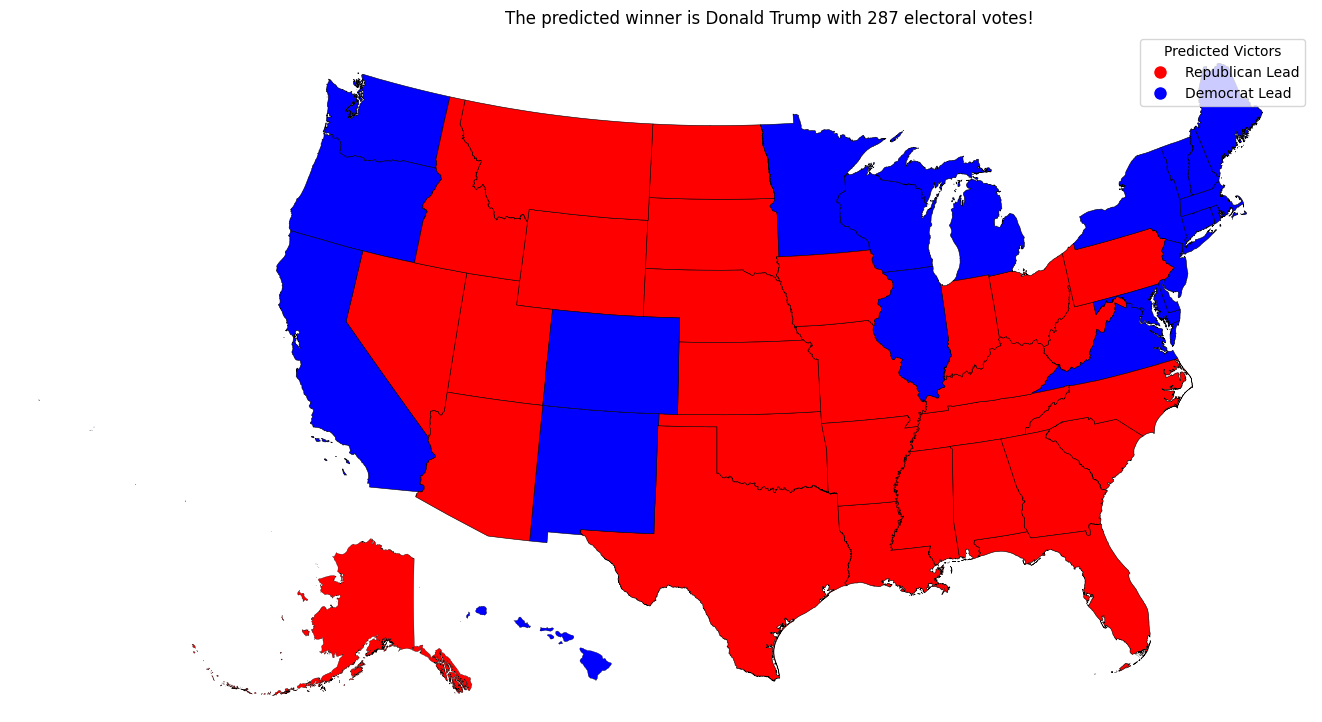

In [19]:
cmap = ListedColormap(['red', 'blue'])
bounds = [0, 0.5, 1]
norm = BoundaryNorm(bounds, cmap.N)
fig, ax = plt.subplots(1, figsize=(14, 14))
ax.axis('off')
gdf.loc[~gdf.state.isin(['Hawaii', 'Alaska'])].plot(column = "value", 
                                                ax = ax, 
                                                cmap=cmap, 
                                                norm = norm,
                                                edgecolor = 'black',
                                                linewidth = .4)

akax = fig.add_axes([.09, 0.21, 0.22, 0.22])   
akax.axis('off')
akax_gdf = gdf.loc[gdf.state == 'Alaska'].copy()
akax_gdf['geometry'] = akax_gdf['geometry'].apply(lambda geom: rotate(geom, 36))
akax_gdf.plot(column = "value", 
              cmap = cmap, 
              ax = akax, 
              norm = norm,
              edgecolor = 'black',
              linewidth = .2)

hiax = fig.add_axes([-.03, 0.15, 0.45, 0.45])   
hiax.axis('off')
hawaii_gdf = gdf.loc[gdf.state == 'Hawaii'].copy()
hawaii_gdf['geometry'] = hawaii_gdf['geometry'].apply(lambda geom: rotate(geom, 45))
hawaii_gdf.plot(column="value", 
                ax = hiax, 
                cmap = cmap, 
                norm = norm,
                edgecolor = 'black',
                linewidth = .2)

rep_win = plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='Republican Lead')
dem_win = plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10, label='Democrat Lead')
ax.legend(handles = [rep_win, dem_win], title = 'Predicted Victors')
if dem_ev >= 270:
    ax.set_title(f"The predicted winner is Kamala Harris with {dem_ev} electoral votes!")
elif rep_ev >= 270:
    ax.set_title(f"The predicted winner is Donald Trump with {rep_ev} electoral votes!")
else:
    ax.set_title("There is no predicted winner, as neither candidate got 270 electoral votes.")

# Credits to : https://medium.com/@alex_44314/use-python-geopandas-to-make-a-us-map-with-alaska-and-hawaii-39a9f5c222c6 

In [20]:
#results.sort_values(by='state')
#results['state'].unique()
#gdf['NAME'].unique()
#gdf.sort_values(by='state')

Prepare the data

In [21]:
'''
# Extract relevant details from unemployment_data
unemployment_data.columns = unemployment_data.columns.str.strip()
unemployment_data['statistic_code'] = unemployment_data['series_id'].str[19:].astype(int)
unemployment_data['state_code'] = unemployment_data['series_id'].str[5:7].astype(int)
unemployment_data['month'] = unemployment_data['period'].str[1:3].astype(int)
unemployment_data['value'] = pd.to_numeric(unemployment_data['value'], errors = 'coerce')
# Merge the datasets
unemployment_data = unemployment_data.merge(unemployment_statistic, left_on='statistic_code', right_on='measure_code', how = 'left')
unemployment_data = unemployment_data.merge(unemployment_state, left_on='state_code', right_on='srd_code', how = 'inner')
unemployment_data = unemployment_data[['srd_text', 'measure_text', 'year', 'month', 'value']].rename(
    columns={
        'srd_text': 'state',
        'measure_text': 'measure'
    }
)
# Pivot the data
unemployment_data = unemployment_data.pivot_table(index=['state', 'year', 'month'],
                                                       columns='measure',
                                                       values='value').reset_index()
'''

"\n# Extract relevant details from unemployment_data\nunemployment_data.columns = unemployment_data.columns.str.strip()\nunemployment_data['statistic_code'] = unemployment_data['series_id'].str[19:].astype(int)\nunemployment_data['state_code'] = unemployment_data['series_id'].str[5:7].astype(int)\nunemployment_data['month'] = unemployment_data['period'].str[1:3].astype(int)\nunemployment_data['value'] = pd.to_numeric(unemployment_data['value'], errors = 'coerce')\n# Merge the datasets\nunemployment_data = unemployment_data.merge(unemployment_statistic, left_on='statistic_code', right_on='measure_code', how = 'left')\nunemployment_data = unemployment_data.merge(unemployment_state, left_on='state_code', right_on='srd_code', how = 'inner')\nunemployment_data = unemployment_data[['srd_text', 'measure_text', 'year', 'month', 'value']].rename(\n    columns={\n        'srd_text': 'state',\n        'measure_text': 'measure'\n    }\n)\n# Pivot the data\nunemployment_data = unemployment_data.piv

In [22]:
'''avg_polling_data['date'] = pd.to_datetime(avg_polling_data['date'])
avg_polling_data = avg_polling_data.sort_values(by='date', ascending=False)
avg_polling_data = avg_polling_data[['candidate', 'date', 'state', 'pct_estimate', 'hi', 'lo']]
avg_polling_data.loc[avg_polling_data['candidate'] == 'Trump', 'pct_estimate'] = 100 - avg_polling_data['pct_estimate']
avg_polling_data.loc[avg_polling_data['candidate'] == 'Trump', 'candidate'] = 'Harris'
#avg_polling_data.loc[avg_polling_data['candidate'] == 'Harris']'''

"avg_polling_data['date'] = pd.to_datetime(avg_polling_data['date'])\navg_polling_data = avg_polling_data.sort_values(by='date', ascending=False)\navg_polling_data = avg_polling_data[['candidate', 'date', 'state', 'pct_estimate', 'hi', 'lo']]\navg_polling_data.loc[avg_polling_data['candidate'] == 'Trump', 'pct_estimate'] = 100 - avg_polling_data['pct_estimate']\navg_polling_data.loc[avg_polling_data['candidate'] == 'Trump', 'candidate'] = 'Harris'\n#avg_polling_data.loc[avg_polling_data['candidate'] == 'Harris']"